In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties
from fair.interface import initialise

from itertools import product


# Preamble 

## The FAIR model 

- The fair model is very similar to the 2 layer model that we discussed in class. The main goal is to simulate a globally averaged surface temperature in a very effecient way, to allow more scenarios to be explored. More detail can be found here: https://docs.fairmodel.net/en/latest/intro.html
- It consists of 3 "gas boxes" that simulate a C cycle, and a 3 layer/mode ocean heat uptake model with a specified feedback parameter. 
- The model can take a set of emissions and concentration data, convert this to ERF, and then use this ERF to force the ocean heat uptake model and simulate the tmeperature.
- There is a version of the model that has stochastic forcing to simulate the effects of internal variability. By default I have turned this off. 

## genFairModel Function  

- This funciton will create a Fair model "object", which you can use to run the model and will also store the data.
- To configure the runs of the model you will need to create new input files, described below.
- There is also the option to run the model with the SSP scenarios used by CMIP6.
- Some examples are shown below.

## Input Files

### Forcing Files 
- For all forcing files, only some years are specified, and linear interpolation is used to fill in any missing years.
- **emissions_file** = for forcings that are simulated by the model (CO2 and Sulphur)
- **concentrations_file** = for forcings that are simulated by concentrations (CH4 and N2O)
- **forcing_file** = for natural forcings that are specified by their ERF (Volvanic)

### Parameter Files 

- **speciesConfig** = this contains all the chemical and physical parameters to convert emissions and concentrations to ERF. Very unlikely that you will need to edit this.
- **climateConfig** = this contains all parameters necessary for running the model. API reference for the fair model The full list can be found at: https://docs.fairmodel.net/en/latest/api_reference.html#fair.energy_balance_model.EnergyBalanceModel
    - The main parameters in climateConfig that you might want to change are:
        - ocean_heat_capacity (np.ndarray) – Ocean heat capacity of each layer (top first), W m-2 yr K-1
        - ocean_heat_transfer (np.ndarray) – Heat exchange coefficient between ocean layers (top first). The first element of this array is akin to the climate feedback parameter, with the convention that stabilising feedbacks are positive (opposite to most climate sensitivity literature). W m-2 K-1

## Adding new parameter sets and scenarios

- **New scenarios**: To add your own scenarios you need to create new lines for each of emissions_file, concentration_file, and forcing_file, for each of the different forcings specified in that file. 
- **New parameter settings**: To add your own parameter settings you need to make a new line in climate_config with a new name that refers to the configuration that you are going to use.

## Running SSP scenarios

- the Fair model has all the information internally to run any scenario from the RCMIP database: https://www.rcmip.org/
- this includes the standard ssp scenarios
- the genFairModel function can be configured to use the ssp scenarios by setting the doSSP arguement.


In [3]:
indir='../data/FAIRData'
def genFairModel(y0=1850,
                 y1=2100,
                 emissions_file=f'{indir}/emissions_testSuite.csv',
                 concentration_file=f'{indir}/concentration_constant_testSuite.csv',
                 forcing_file=f'{indir}/natural_forcing_testSuite.csv',
                 speciesConfig=f'{indir}/species_configs_properties.csv',
                 climateConfig=f'{indir}/configs_central_no_stochastic.csv',
                 scenarios=["constant"],
                 configs=["central"],
                 doSSP=False,
                 sspList=None,
                 ):

    # create a fair object
    f = FAIR()

    # define the time range
    # this needs to be in the range specificed by the
    # emissions/concentration/forcing files 
    f.define_time(y0,y1,1)

    # user defined scenarios
    if doSSP:

        # pick scenarios from ssp
        f.define_scenarios(sspList)

        # define the climate configuration - this needs to make whats in the configuration file later
        f.define_configs(configs)

        # input the species properties
        species, properties = read_properties(f'{indir}/species_configs_properties.csv')
        f.define_species(species, properties)

        # allocate arrays 
        f.allocate()

        # get any missing ERF properties
        f.fill_from_rcmip()

        # add the species properties
        f.fill_species_configs(f'{indir}/species_configs_properties.csv')


    else:
        # define user scenarios
        f.define_scenarios(scenarios)

        # define the climate configuration - this needs to make whats in the configuration file later
        f.define_configs(configs)

        # get the species properties - probably never need to modify this line.
        species, properties = read_properties(speciesConfig)
        f.define_species(species, properties)

        # set up the fair object and put the data in 
        f.allocate()

        f.fill_from_csv(
            emissions_file=emissions_file,
            concentration_file=concentration_file,
            forcing_file=forcing_file
        )

        f.fill_species_configs(speciesConfig)

    # reload the climate configuration to make sure nothing has changed
    f.override_defaults(climateConfig)

    # set the intial values of everything 
    initialise(f.concentration, f.species_configs['baseline_concentration'])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)
    initialise(f.ocean_heat_content_change, 0)

    return f


Running 1 projections in parallel:   0%|          | 0/250 [00:00<?, ?timesteps/s]

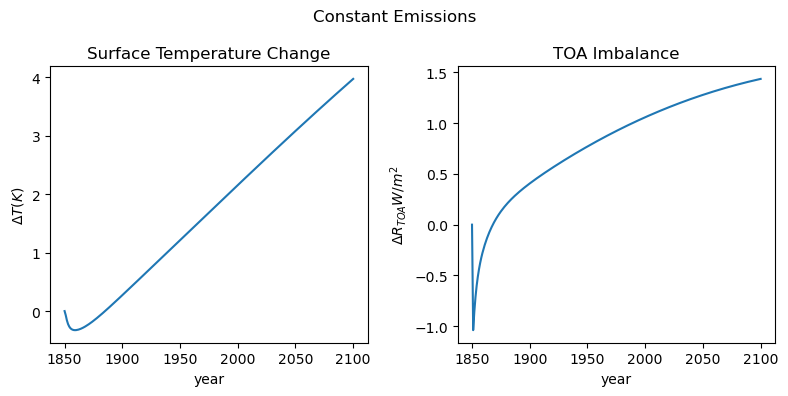

In [4]:
f=genFairModel(
                 scenarios=["constant"],
                 configs=["central"],
)
f.run()

y=np.arange(1850,2101,1)

figure=plt.figure(0,figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(y,f.temperature.isel(config=0,layer=0))
plt.ylabel('$\Delta T (K)$')
plt.xlabel('year')
plt.title('Surface Temperature Change')

plt.subplot(1,2,2)
plt.plot(y,f.toa_imbalance.isel(config=0))
plt.ylabel('$\Delta R_{TOA} W/m^2$')
plt.xlabel('year')
plt.title('TOA Imbalance')

plt.suptitle('Constant Emissions')
plt.tight_layout()


Running 1 projections in parallel:   0%|          | 0/350 [00:00<?, ?timesteps/s]

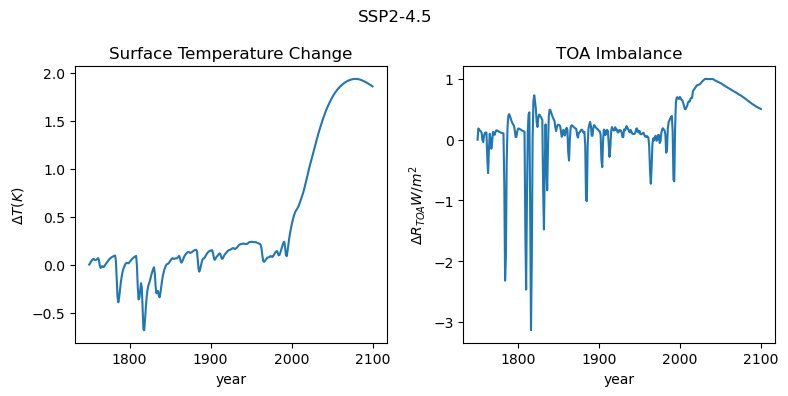

In [5]:
f=genFairModel(doSSP=True,sspList=['ssp126'],y0=1750)
f.run()

y=np.arange(1750,2101,1)

figure=plt.figure(0,figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(y,f.temperature.isel(config=0,layer=0))
plt.ylabel('$\Delta T (K)$')
plt.xlabel('year')
plt.title('Surface Temperature Change')

plt.subplot(1,2,2)
plt.plot(y,f.toa_imbalance.isel(config=0))
plt.ylabel('$\Delta R_{TOA} W/m^2$')
plt.xlabel('year')
plt.title('TOA Imbalance')

plt.suptitle('SSP2-4.5')
plt.tight_layout()

# Questions 

## 1 - Test Suite Experiments  

- run and plot the following experiments from the test Suite: constant, constant_noS, and ramp, for the time period 1850 to 2500. (hint: open the file emissions_testSuite.csv to see what is inside).
- Are any of the simulations in equillibrium? Why or why not?
- Briefly compare the constant and constant_noS experiment. What impacts does Sulphur emissions have on the temperature evolution?
- How much does having the ramp emissions delay global warming?

## 2 - Varying the Climate Feedback Parameter

### 2.1 - Idealized Forcing Experiment 

- The IPCC AR6 report gives the most likely ECS range as [2.5,4], with a central estimate of 3. Using a CO2 forcing at 2XCO2 of 3.93 W/m^2, calculate a feedback parameter for the high, central, and low estimates of the ECS.
- Add new parameter sets with these new feedback parameters (leaving the rest the same) to the model and run the ramp experiment. What does this do to the model simulations?

### 2.2 - SSP Scenarios with varying Feedbacks
- Run and plot the following SSP scenarios: ssp126, ssp245, ssp460, ssp370, ssp585, using the three values of the climate feedback parameter in the previous section. Do all the simulations between 1750 and 2100.
- how does the temperature range simulated at 2100 vary with scenario. Why is this?

Hint: the ```plt.fill_between``` with alpha=0.5 is very useful for showing ranges of data. You don't have to use it though. 


## 3 - Time of 2K temperature change 
- Define $y_2$ as the first year where the global temperature change is at least 2 degrees, and NaN if the temperature does not reach 2 degrees.
- Calculate $y_2$ for all of the SSP scenarios with all of the different feedback parameters that were considered in the last question. Show your calculations with either a table or a plot.
- If the prime minister asked you if and/or when the world would hit the 2K temperature change goal, what would you tell them (in 3 sentences or less)? If there are uncertainties, explain what these are and their relative signifigance.

Hint: There are (at least) two ways to claculate $y_2$:
1. Using the `np.min` and `np.where` functions (e.g. https://www.digitalocean.com/community/tutorials/python-numpy-where) 
2. Using a for loop with a break statement in it (e.g. https://www.programiz.com/python-programming/break-continue) 

# Answers 

## 1 - Test Suite Experiments  

- See figure 1
- No, the TOA imbalance is not zero.
- Sulphur emissions cause an intial cooling, and reduce the peak warming. This is because sulphate areosols have an opposite effect to CO2 on the TOA imbalance.
- the ramp emissions delay global warming by 100-200 years.

## 2 - Varying the Climate Feedback Parameter

### 2.1 - Idealized Forcing Experiment 

- High: 3.93/4 = 0.9825, Central: 3.93/3 = 1.31, low = 3.93/2.5 = 1.572
- This is done in the file ``` configs_sensitivity_high_central_low.csv```. See figure 2. The high (low) sensitivty run warms more (less) than the central experiment. 


### 2.2 - SSP Scenarios with varying Feedbacks
- See figure 3. 
- The temperature range is higher for the high emission scenarios (e.g. ssp585) than for the low emission scenario (e.g. ssp126). This is because the larger forcing creates a larger response for a small feedback parameter.


## 3 - Time of 2K temperature change 
- See figure 4.
- The differences between scenarios is relatively small, because 2K of warming will happen before the scenarios diverge significantly. However, the uncertainties in the feedback parameter prevent a determination of year when the world will cross 2K beyond saying that it will occur approximatley between 2040 and 2070.

# Question 1

Running 3 projections in parallel:   0%|          | 0/650 [00:00<?, ?timesteps/s]

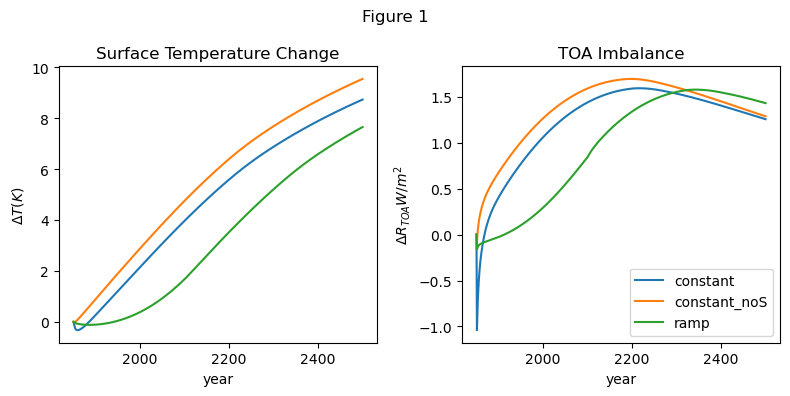

In [6]:
scenarios=["constant","constant_noS","ramp"]
f=genFairModel(
    y1=2500,
    climateConfig=f'{indir}/configs_sensitivity_high_central_low.csv',
    scenarios=scenarios,
                 configs=["central"],
)
f.run()

y=np.arange(1850,2501,1)

figure=plt.figure(0,figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(y,f.temperature.isel(config=0,layer=0))
plt.ylabel('$\Delta T (K)$')
plt.xlabel('year')
plt.title('Surface Temperature Change')

plt.subplot(1,2,2)
plt.plot(y,f.toa_imbalance.isel(config=0),label=scenarios)
plt.ylabel('$\Delta R_{TOA} W/m^2$')
plt.xlabel('year')
plt.title('TOA Imbalance')
plt.legend()

plt.suptitle('Figure 1')
plt.tight_layout()


# Question 2.1 

Running 9 projections in parallel:   0%|          | 0/650 [00:00<?, ?timesteps/s]

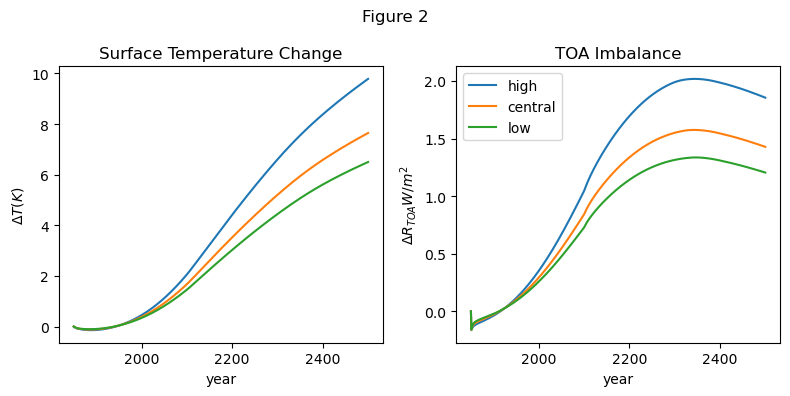

In [7]:
scenarios=["constant","constant_noS","ramp"]
configs=["high","central","low"]
f=genFairModel(
    y1=2500,
    climateConfig=f'{indir}/configs_sensitivity_high_central_low.csv',
    scenarios=scenarios,
                 configs=configs,
)
f.run()

figure=plt.figure(0,figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(f.timebounds,f.temperature.isel(scenario=-1,layer=0))
plt.ylabel('$\Delta T (K)$')
plt.xlabel('year')
plt.title('Surface Temperature Change')

plt.subplot(1,2,2)
plt.plot(f.timebounds,f.toa_imbalance.isel(scenario=-1),label=configs)
plt.ylabel('$\Delta R_{TOA} W/m^2$')
plt.xlabel('year')
plt.title('TOA Imbalance')
plt.legend()

plt.suptitle('Figure 2')
plt.tight_layout()


# Question 2.2

Running 15 projections in parallel:   0%|          | 0/350 [00:00<?, ?timesteps/s]

Text(0.5, 0.98, 'Figure 3')

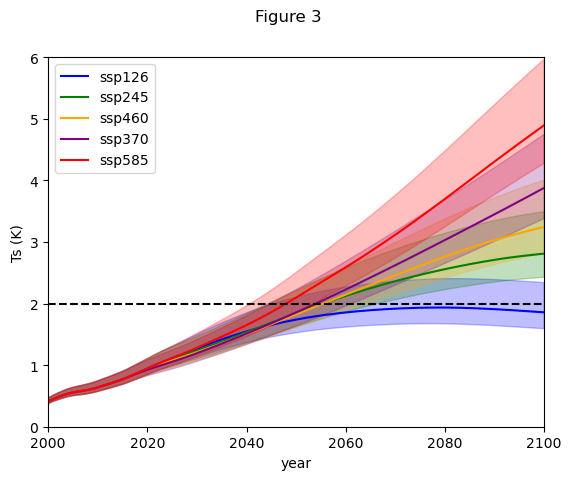

In [8]:
sspList = ['ssp126','ssp245','ssp460','ssp370','ssp585']
f = genFairModel(y0=1750,
                 y1=2100,
                doSSP=True,
                climateConfig=f'{indir}/configs_sensitivity_high_central_low.csv',
                sspList=sspList,
                configs=["high","central","low"]
)
f.run()

colors=['blue','green','orange','purple','red']

for i in range(0,5):
    plt.fill_between(y1=f.temperature.data[:,i,0,0],
                     y2=f.temperature.data[:,i,2,0],
                     x=np.arange(1750,2101,1),
                     alpha=0.25,
                     color=colors[i])
    plt.plot(np.arange(1750,2101,1),
             f.temperature.data[:,i,1,0],
             label=sspList[i],
             color=colors[i])
plt.legend()
plt.axhline(2,linestyle='--',color='k')
plt.xlim([2000,2100])
plt.ylim([0,6])
plt.xlabel('year')
plt.ylabel('Ts (K)')
plt.suptitle('Figure 3')


# Question 3

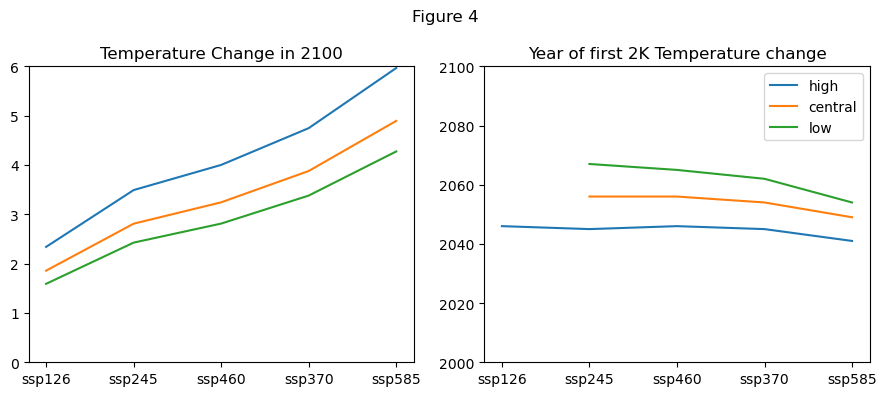

In [15]:
ycrossing_2 = np.zeros([len(sspList),3])
for i,j in product(range(0,len(sspList)),range(0,3)):
    try:
        ycrossing_2[i,j]=\
            f.timebounds.data[np.min(np.where(f.temperature.data[:,i,j,0]-2>=0))]
    except:
        ycrossing_2[i,j]=np.nan

plt.figure(0,figsize=(9,4))
plt.subplot(1,2,1)

# find the distribution of temperatures 
plt.title('Temperature Change in 2100')
plt.plot(sspList,f.temperature.sel(timebounds=2100,layer=0))
plt.ylim([0,6])

plt.subplot(1,2,2)

plt.title('Year of first 2K Temperature change')
plt.plot(sspList,ycrossing_2,label=['high','central','low'])
plt.legend()
plt.ylim([2000,2100])

plt.suptitle('Figure 4')


plt.tight_layout()

In [10]:
# alternate solution if you are less familiar with numpy functions 

def get_y2(timeseries,years):
    k=0
    while k<len(timeseries):
        if timeseries[k]>2:
            break
        k+=1
    if k==len(timeseries):
        print('no y2 found')
        return np.nan
    else:
        return years[k]
    
years = f.timepoints.data

y2_array = np.zeros([5,3])

for i,j in product(range(0,5),range(0,3)):
    print(i,j)
    y2_array[i,j] = get_y2(f.temperature.values[:,i,j,0], years)

print(y2_array)

0 0
0 1
no y2 found
0 2
no y2 found
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2
[[2046.5    nan    nan]
 [2045.5 2056.5 2067.5]
 [2046.5 2056.5 2065.5]
 [2045.5 2054.5 2062.5]
 [2041.5 2049.5 2054.5]]


f.timebounds